# Worksheet 9 - Regression Continued

### Lecture and Tutorial Learning Goals:

By the end of the week, you will be able to:

* Recognize situations where a simple regression analysis would be appropriate for making predictions.
* Explain the $k$-nearest neighbour ($k$-nn) regression algorithm and describe how it differs from k-nn classification.
* Interpret the output of a $k$-nn regression.
* In a dataset with two variables, perform $k$-nearest neighbour regression in R using `tidymodels` to predict the values for a test dataset.
* Using R, execute cross-validation in R to choose the number of neighbours.
* Using R, evaluate $k$-nn regression prediction accuracy using  a test data set and an appropriate metric (*e.g.*, root means square prediction error).
* In a dataset with > 2 variables, perform $k$-nn regression in R using `tidymodels` to predict the values for a test dataset.
* In the context of $k$-nn regression, compare and contrast goodness of fit and prediction properties (namely RMSE vs RMSPE).
* Describe advantages and disadvantages of the $k$-nearest neighbour regression approach.
* Perform ordinary least squares regression in R using `tidymodels` to predict the values for a test dataset.
* Compare and contrast predictions obtained from $k$-nearest neighbour regression to those obtained using simple ordinary least squares regression from the same dataset.

This worksheet covers parts of [the Regression II chapter](https://datasciencebook.ca/regression2.html) of the online textbook. You should read this chapter before attempting the worksheet.

In [1]:
### Run this cell before continuing.
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
options(repr.matrix.max.rows = 6)
source("tests.R")
source('cleanup.R')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

### Warm-up Questions

Here are some warm-up questions on the topic of multiple regression to get you thinking before we jump into data analysis. The course readings should help you answer these.

**Question 1.0** Multiple Choice: 
<br> {points: 1}

In multivariate k-nn regression with one outcome/target variable and two predictor variables, the predictions take the form of what shape?

A. a flat plane

B. a wiggly/flexible plane

C. A straight line

D. a wiggly/flexible line

E. a 4D hyperplane

F. a 4D wiggly/flexible hyperplane

Save the letter of the answer you think is correct to a variable named `answer1.0`. Make sure you put quotations around the letter and pay attention to case.

In [2]:
# your code here
answer1.0 <- "B"

In [3]:
test_1.0()

Test passed 🎉
Test passed 🎉
[1] "Success!"


**Question 1.1** Multiple Choice: 
<br> {points: 1}

In simple linear regression with one outcome/target variable and one predictor variable, the predictions take the form of what shape?

A. a flat plane

B. a wiggly/flexible plane

C. A straight line

D. a wiggly/flexible line

E. a 4D hyperplane

F. a 4D wiggly/flexible hyperplane

Save the letter of the answer you think is correct to a variable named `answer1.1`. Make sure you put quotations around the letter and pay attention to case.

In [4]:
# your code here
answer1.1 <- "C"

In [5]:
test_1.1()

Test passed 🎊
Test passed 😀
[1] "Success!"


**Question 1.2** Multiple Choice: 
<br> {points: 1}

In multiple linear regression with one outcome/target variable and two predictor variables, the predictions take the form of what shape?

A. a flat plane

B. a wiggly/flexible plane

C. A straight line

D. a wiggly/flexible line

E. a 4D hyperplane

F. a 4D wiggly/flexible hyperplane

Save the letter of the answer you think is correct to a variable named `answer1.2`. Make sure you put quotations around the letter and pay attention to case.

In [6]:
# your code here
answer1.2 <- "A"

In [7]:
test_1.2()

Test passed 🥳
Test passed 🎊
[1] "Success!"


### Understanding Simple Linear Regression

Consider this small and simple dataset: 

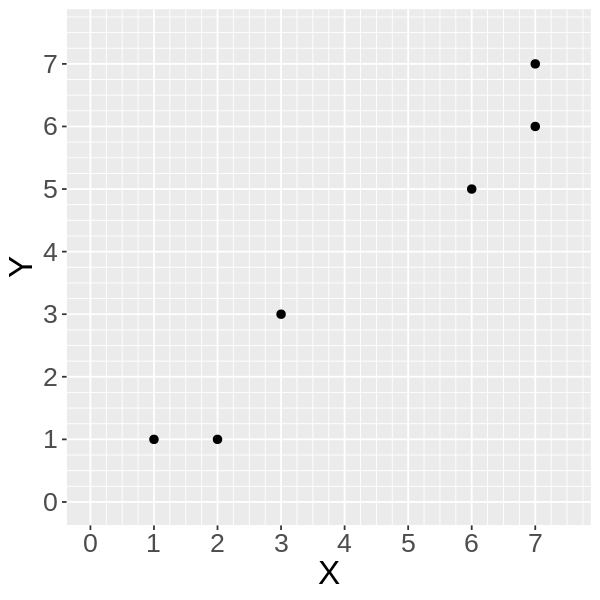

In [8]:
simple_data  <- tibble(X = c(1, 2, 3, 6, 7, 7),
               Y = c(1, 1, 3, 5, 7, 6))
options(repr.plot.width = 5, repr.plot.height = 5)
base <- ggplot(simple_data, aes(x = X, y = Y)) +
    geom_point(size = 2) +
    scale_x_continuous(limits = c(0, 7.5), breaks = seq(0, 8), minor_breaks = seq(0, 8, 0.25)) +
    scale_y_continuous(limits = c(0, 7.5), breaks = seq(0, 8), minor_breaks = seq(0, 8, 0.25)) +
    theme(text = element_text(size = 20))
base 

Now consider these three **potential** lines we could fit for the same dataset:

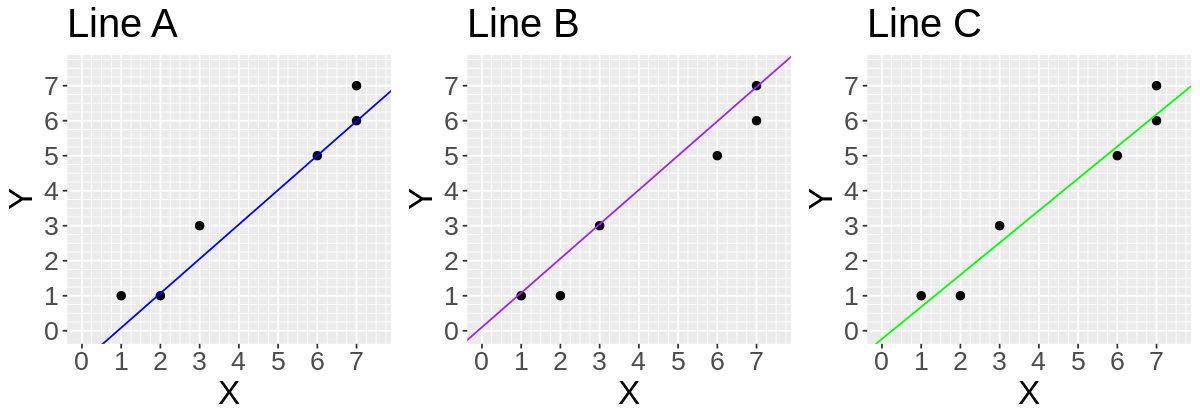

In [9]:
options(repr.plot.height = 3.5, repr.plot.width = 10)
line_a <- base +
    ggtitle("Line A") +
    geom_abline(intercept = -0.897, slope = 0.9834, color = "blue") +
    theme(text = element_text(size = 20))
line_b <- base +
    ggtitle("Line B") +
    geom_abline(intercept = 0.1022, slope = 0.9804, color = "purple") +
    theme(text = element_text(size = 20))
line_c <- base +
    ggtitle("Line C") +
    geom_abline(intercept = -0.2347, slope = 0.9164, color = "green") +
    theme(text = element_text(size = 20))
plot_grid(line_a, line_b, line_c, ncol = 3)

**Question 2.0**
<br> {points: 1}

Use the graph below titled "Line A" to roughly calculate the average squared vertical distance between the points and the blue line. Read values of the graph to a **precision of 0.25** (e.g. 1, 1.25, 1.5, 1.75, 2). Save your answer to a variable named `answer2.0`. 

*We reprint the plot for you in a larger size to make it easier to estimate the locations on the graph.*

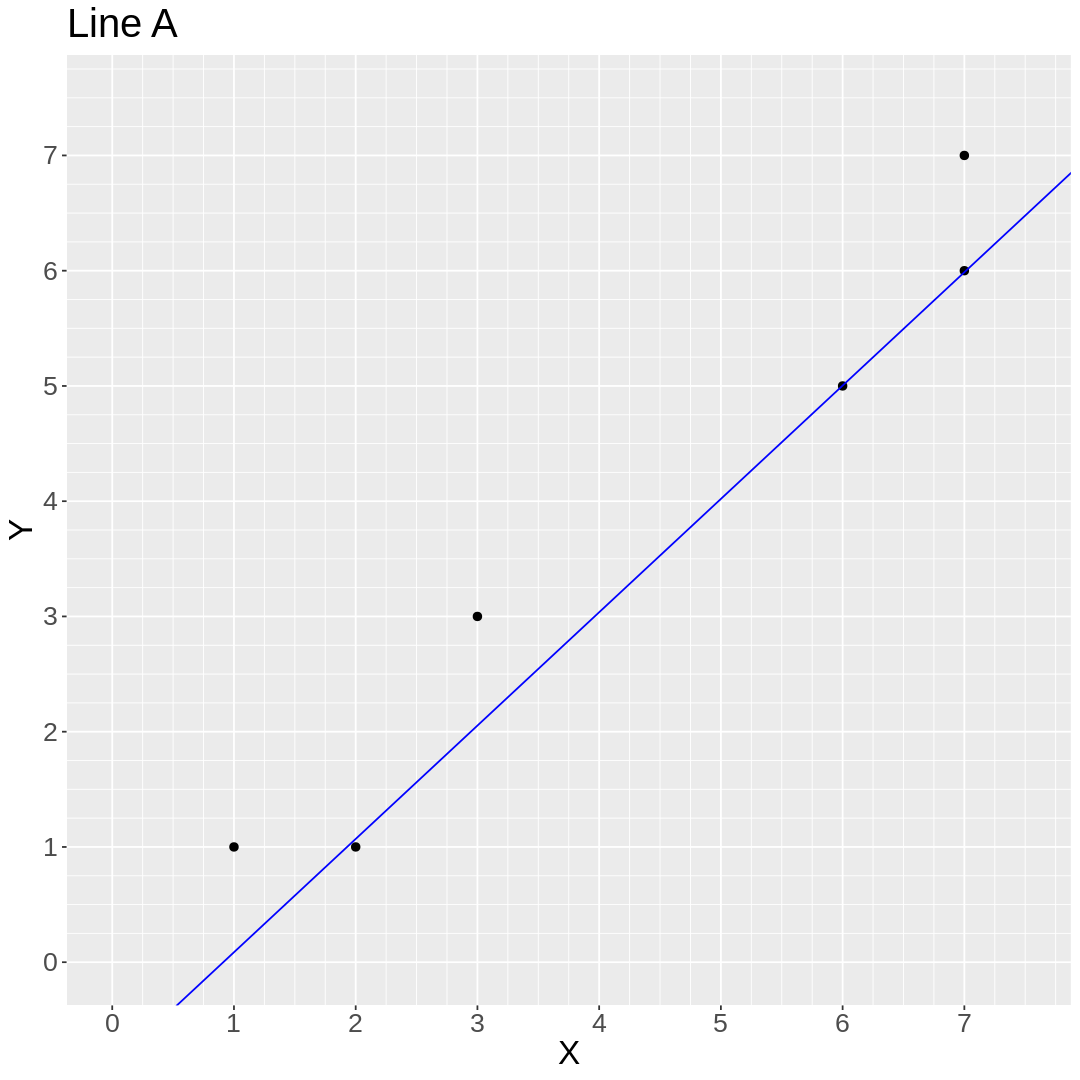

In [10]:
#run this code
options(repr.plot.width = 9, repr.plot.height = 9)
line_a

In [11]:
# your code here
answer2.0 <- ((1-0)^2 + (1-1)^2 + (3-2)^2 + (5-5)^2 + (6-6)^2 + (7-6)^2)/6
answer2.0

[1] 0.5

In [12]:
test_2.0()

Test passed 😸
Test passed 🎉
[1] "Success!"


**Question 2.1**
<br> {points: 1}

Use the graph titled "Line B" to roughly calculate the average squared vertical distance between the points and the purple line. Read values of the graph to a **precision of 0.25** (e.g. 1, 1.25, 1.5, 1.75, 2). Save your answer to a variable named `answer2.1`. 

*We reprint the plot for you in a larger size to make it easier to estimate the locations on the graph.*

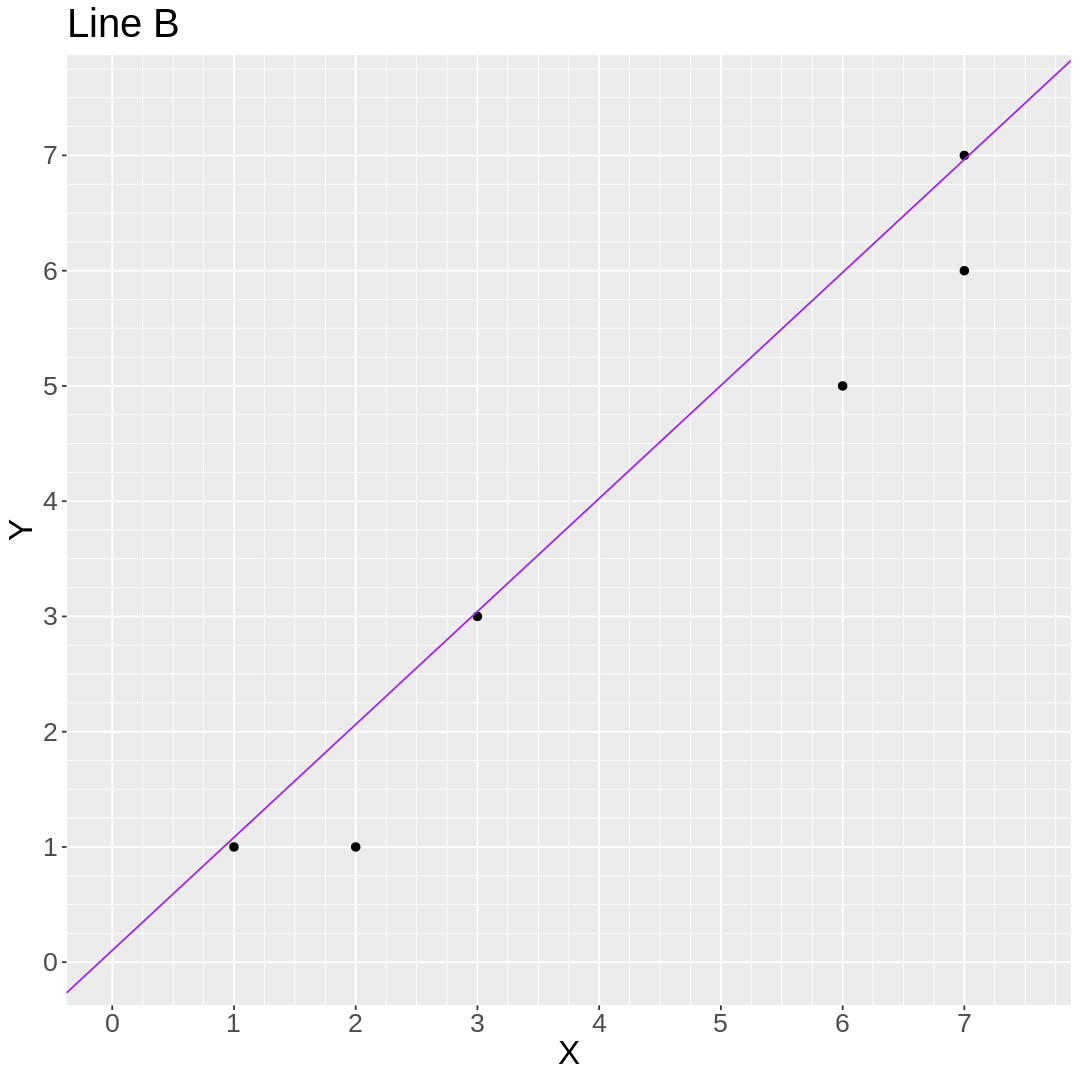

In [13]:
options(repr.plot.width = 9, repr.plot.height = 9)
line_b

In [14]:
# your code here
answer2.1 <- ((1-1)^2 + (1-2)^2 + (3-3)^2 + (5-6)^2 + (6-7)^2 + (7-7)^2)/6

In [15]:
test_2.1()

Test passed 😸
Test passed 😸
[1] "Success!"


**Question 2.2** 
<br> {points: 1}

Use the graph titled "Line C" to roughly calculate the average squared vertical distance between the points and the green line. Read values of the graph to a **precision of 0.25** (e.g. 1, 1.25, 1.5, 1.75, 2). Save your answer to a variable named `answer2.2`. 

*We reprint the plot for you in a larger size to make it easier to estimate the locations on the graph.*

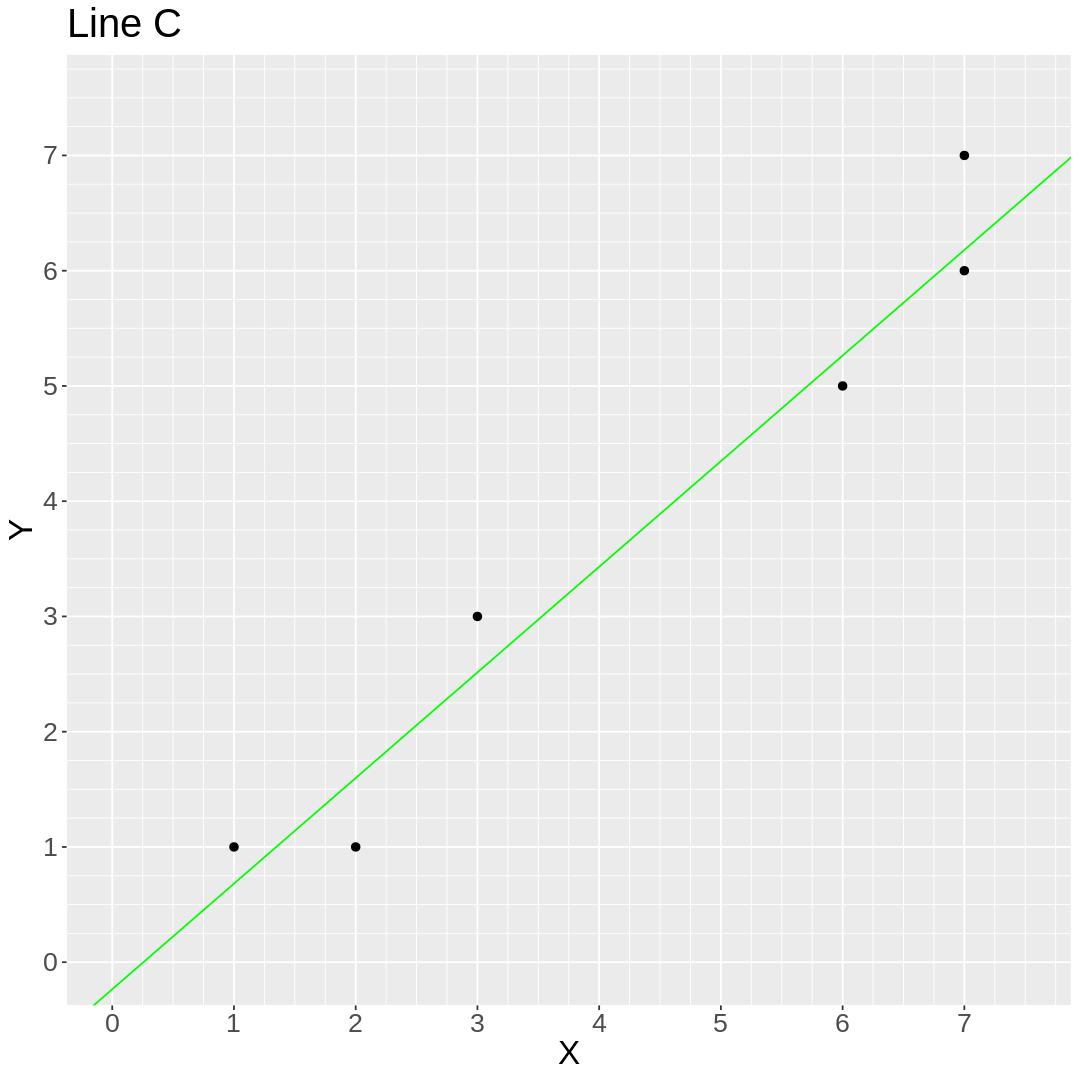

In [16]:
options(repr.plot.width = 9, repr.plot.height = 9)
line_c

In [17]:
# your code here
answer2.2 <- ((1-0.75)^2+(1-1.5)^2+(3-2.5)^2+(5-5.25)^2+(6-6.25)^2+(7-6.25)^2)/6


In [18]:
test_2.2()

Test passed 😸
Test passed 😀
[1] "Success!"


**Question 2.3**
<br> {points: 1}

Based on your calculations above, which line would linear regression by ordinary least squares choose given our small and simple dataset? Line A, B or C? Assign the letter that corresponds the line to a variable named `answer2.3`. Make sure you put quotations around the letter and pay attention to case.

In [19]:
# your code here
answer2.3 <- "C"

In [20]:
test_2.3()

Test passed 🎊
Test passed 🥇
[1] "Success!"


## Marathon Training Revisited with Linear Regression!

<img src='https://media.giphy.com/media/BDagLpxFIm3SM/giphy.gif' width='400'>

Source: https://media.giphy.com/media/BDagLpxFIm3SM/giphy.gif

Remember our question from last week: what features predict whether athletes will perform better than others? Specifically, we are interested in marathon runners, and looking at how the maximum distance ran per week during training predicts the time it takes a runner to end the race? 

This time around, however, we will analyze the data using simple linear regression rather than $k$-nn regression. In the end, we will compare our results to what we found last week with $k$-nn regression.

**Question 3.0**
<br> {points: 1}

Load the `marathon` data and assign it to an object called `marathon`. 

In [21]:
# your code here

marathon <- read_csv("data/marathon.csv")
marathon

Rows: 929 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (13): age, bmi, female, footwear, group, injury, mf_d, mf_di, mf_ti, max...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,bmi,female,footwear,group,injury,mf_d,mf_di,mf_ti,max,sprint,mf_s,time_hrs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
35,23.59232,0,2,1,2,42195,4,10295,60,1,4.098592,2.859722
33,22.51830,0,2,2,2,42195,3,12292,50,0,3.432720,3.414444
38,25.56031,0,2,3,1,42195,4,10980,65,0,3.842896,3.050000
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
44,24.23762,0,2,3,1,42195,2,12289,63,1,3.433558,3.413611
34,21.24975,0,2,3,1,42195,3,12602,32,0,3.348278,3.500556
41,25.20479,0,2,1,1,42195,2,13500,20,1,3.125556,3.750000


In [22]:
test_3.0()

Test passed 😸
Test passed 😸
Test passed 😸
Test passed 🎉
Test passed 😀
[1] "Success!"


**Question 3.1**
<br> {points: 1}

Similar to what we have done for the last few weeks, we will first split the dataset into the training and testing datasets, using 75% of the original data as the training data. Remember, we will be putting the test dataset away in a 'lock box' that we will comeback to later after we choose our final model. In the `strata` argument of the `initial_split` function, place the variable we are trying to predict. Assign your split dataset to an object named `marathon_split`. 

Assign your training dataset to an object named `marathon_training` and your testing dataset to an object named `marathon_testing`.

In [23]:
set.seed(2000) # DO NOT CHANGE THIS

marathon_split <- initial_split(marathon, prop = 0.75, strata = time_hrs)
marathon_training <- training(marathon_split)
marathon_testing <- testing(marathon_split)

In [24]:
test_3.1()

Test passed 🥳
Test passed 🥳
Test passed 😀
Test passed 🎊
Test passed 😸
Test passed 🥳
Test passed 😸
Test passed 🥳
Test passed 😸
[1] "Success!"


**Question 3.2**
<br> {points: 1}

Using only the observations in the training dataset, create a scatterplot to assess the relationship between race time (`time_hrs`) and maximum distance ran per week during training (`max`). Put `time_hrs` on the y-axis and `max` on the x-axis. Assign this plot to an object called `marathon_eda`. Remember to do whatever is necessary to make this an effective visualization.

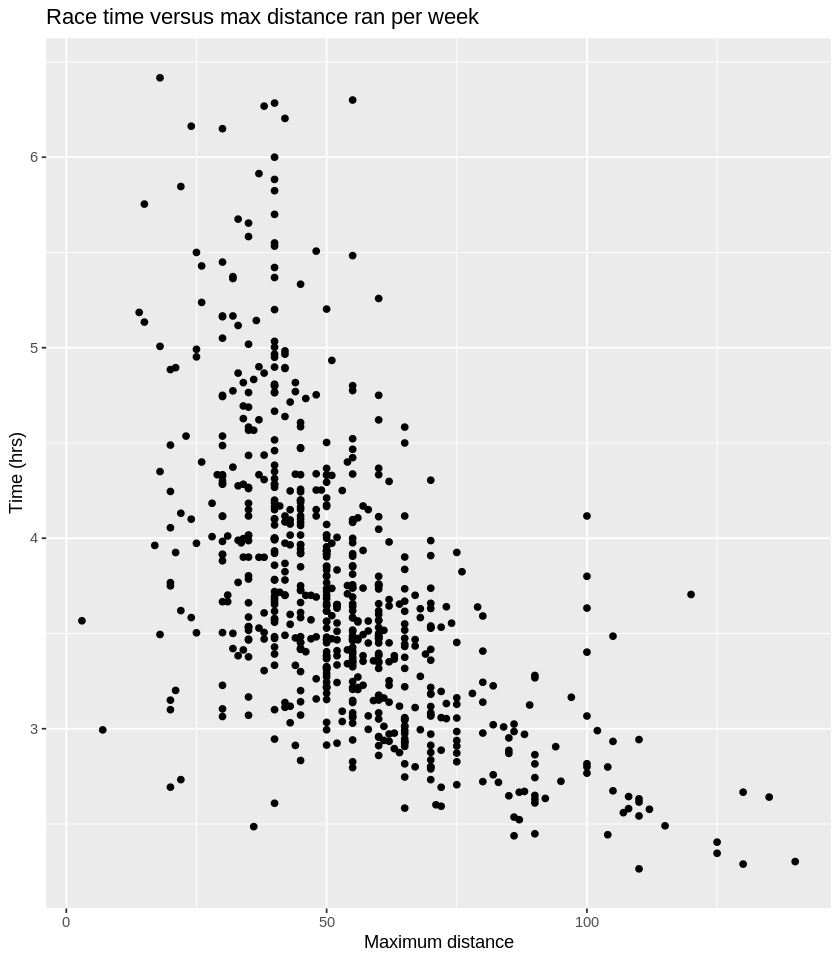

In [29]:
options(repr.plot.height = 8, repr.plot.width = 7)

marathon_eda <- marathon_training |>
    ggplot(aes(x = max, y = time_hrs)) + 
        geom_point() +
        xlab("Maximum distance") +
        ylab("Time (hrs)") +
        ggtitle("Race time versus max distance ran per week")
marathon_eda

In [30]:
test_3.2()

Test passed 🌈
Test passed 😸
Test passed 🎊
Test passed 🥇
Test passed 🎉
Test passed 🥇
[1] "Success!"


**Question 3.3**
<br> {points: 1}

Now that we have our training data, the next step is to build a linear regression model specification. Thankfully, building other model specifications is quite straightforward since we will still go through the same procedure (indicate the function, the engine and the mode). 

Instead of using the `nearest_neighbor` function, we will be using the `linear_reg` function to let `tidymodels` know we want to perform a linear regression. In the `set_engine` function, we have typically set `"kknn"` there for $k$-nn. Since we are doing a linear regression here, set `"lm"` as the engine. Finally, instead of setting `"classification"` as the mode, set `"regression"` as the mode. 

Assign your answer to an object named `lm_spec`.

In [31]:
# your code here

lm_spec <- linear_reg() |>
    set_engine("lm") |>
    set_mode("regression")

In [32]:
test_3.3()

Test passed 🎊
Test passed 🥳
Test passed 🎊
[1] "Success!"


**Question 3.3.1**
<br>{points: 1}

After we have created our linear regression model specification, the next step is to create a recipe, establish a workflow analysis and fit our simple linear regression model. 

First, create a recipe with the variables of interest (race time and max weekly training distance) using the training dataset and assign your answer to an object named `lm_recipe`. 

Then, create a workflow analysis with our model specification and recipe. Remember to fit in the training dataset as well. Assign your answer to an object named `lm_fit`.  

In [33]:
lm_recipe <- recipe(time_hrs ~ max, data = marathon_training)

lm_fit <- workflow() |>
       add_recipe(lm_recipe) |>
       add_model(lm_spec) |>
       fit(marathon_training)

lm_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)          max  
     4.8794      -0.0215  


In [34]:
test_3.3.1()

Test passed 😀
Test passed 🥳
Test passed 🌈
Test passed 🎉
Test passed 😸
Test passed 😸
Test passed 😀
[1] "Success!"


**Question 3.4**
<br> {points: 1}

Now, let's visualize the model predictions as a straight line overlaid on the training data. Use the `predict`  and `bind_cols` functions on `lm_fit` to create predictions for the `marathon_training` data. Name the resulting data frame `marathon_preds`.

Next, create a scatterplot with the marathon time (y-axis) against the maximum distance run per week (x-axis) from `marathon_preds`. Use an alpha value of 0.4 to avoid overplotting. **Plot the predictions as a black line over the data points.** Assign your plot to a variable called `lm_predictions`.  Remember the fundamentals of effective visualizations such as having a human-readable axes titles. 

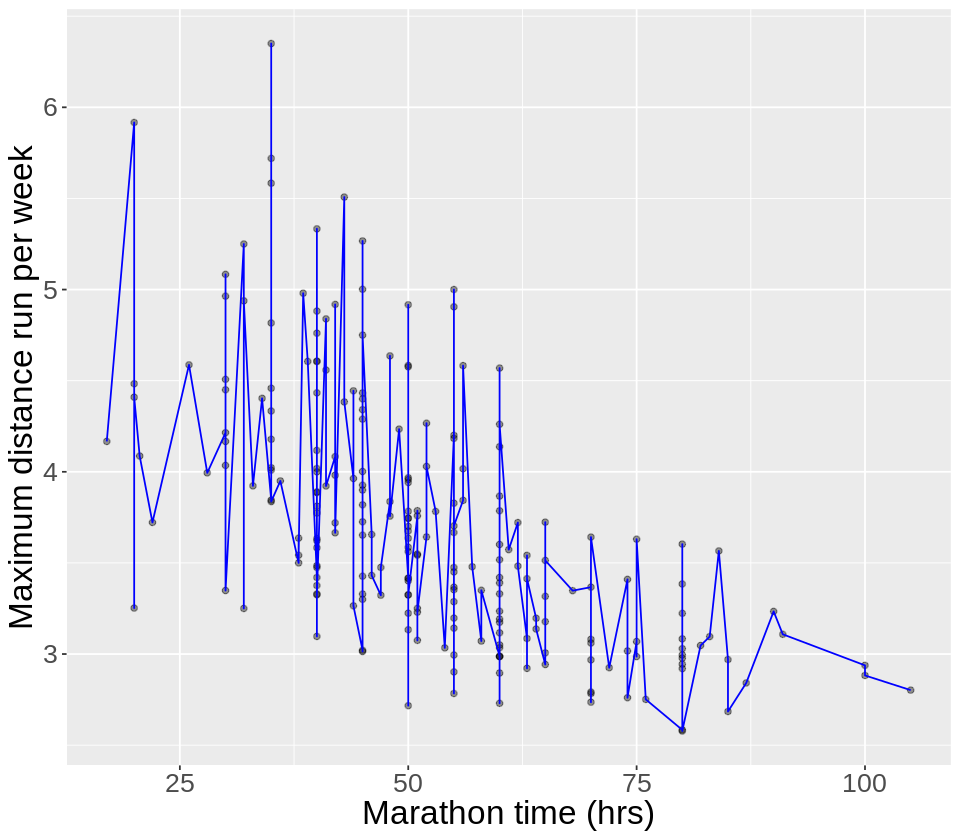

In [40]:
options(repr.plot.width = 8, repr.plot.height = 7)

 marathon_preds <- lm_fit |>
   predict(marathon_testing) |>
   bind_cols(marathon_testing)

 lm_predictions <- marathon_preds |>
     ggplot(aes(x = max, y = time_hrs)) +
         geom_point(alpha = 0.4) +
         geom_line(
             mapping = aes(x = max, y = time_hrs), 
             color = "blue") +
         xlab("Marathon time (hrs)") +
         ylab("Maximum distance run per week") +
         theme(text = element_text(size = 20))

lm_predictions

In [42]:
test_3.4()

Test passed 🥇
Test passed 🎊
Test passed 🥇
Test passed 🎉
Test passed 🌈
Test passed 🌈
[1] "Success!"


**Question 3.5**
<br> {points: 1}

Great! We can now see the line of best fit on the graph. Now let's calculate the $RMSPE$ using the **test data**. To get to this point, first, use the `lm_fit` to make predictions on the test data. Remember to bind the appropriate columns for the test data. Afterwards, collect the metrics and store it in an object called `lm_test_results`.

From `lm_test_results`, extract the $RMPSE$ and return a single numerical value. Assign your answer to an object named `lm_rmspe`.

In [45]:
lm_test_results <- lm_fit |>
         predict(marathon_testing) |>
         bind_cols(marathon_testing) |>
         metrics(truth = time_hrs, estimate = .pred)

lm_rmspe <- lm_test_results |>
          filter(.metric == 'rmse') |>
          select(.estimate) |>
          pull()

lm_rmspe

[1] 0.5504829

In [46]:
test_3.5()

Test passed 🥳
Test passed 🎊
Test passed 🌈
Test passed 😀
Test passed 🎉
Test passed 😸
[1] "Success!"


**Question 3.5.1**
<br> {points: 1}

Now, let's visualize the model predictions as a straight line overlaid on the test data. First, create a scatterplot to assess the relationship between race time (`time_hrs`) and maximum distance ran per week during training (`max`) on the **testing data.** Use and alpha value of 0.4 to avoid overplotting. Then add a line to the plot corresponding to the predictions from the fit linear regression model. Remember to do whatever is necessary to make this an effective visualization.

*Assign the plot to an object called `lm_predictions_test`.*

.pred,age,bmi,female,footwear,group,injury,mf_d,mf_di,mf_ti,max,sprint,mf_s,time_hrs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.804220,33,22.51830,0,2,2,2,42195,3,12292,50,0,3.432720,3.414444
3.911739,53,23.16775,0,2,1,1,42195,3,10875,45,1,3.880000,3.020833
4.040762,34,23.58257,1,2,2,1,42195,3,16580,39,0,2.544934,4.605556
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
4.126777,46,21.89050,1,2,2,1,42195,3,13812,35,1,3.054952,3.836667
4.234296,35,24.34137,0,2,3,1,42195,3,12055,30,0,3.500207,3.348611
3.524670,44,24.23762,0,2,3,1,42195,2,12289,63,1,3.433558,3.413611


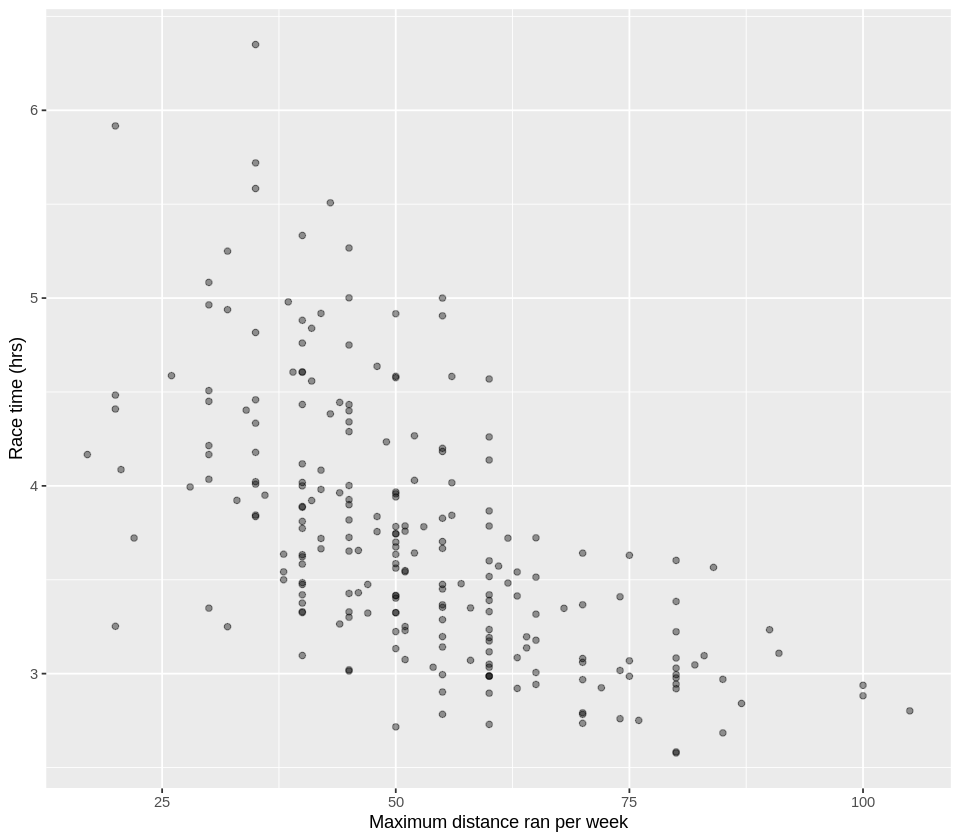

In [55]:
options(repr.plot.width = 8, repr.plot.height = 7)

 test_preds <- lm_fit |>
    predict(marathon_testing) |>
    bind_cols(marathon_testing)
    
 lm_predictions_test <- test_preds |>
    ggplot(aes(x = max, y = time_hrs)) +
    geom_point(alpha = 0.4) +
    ylab("Race time (hrs)") +
    xlab("Maximum distance ran per week")


test_preds
lm_predictions_test

In [56]:
test_3.5.1()

Test passed 😸
Test passed 😸
Test passed 🎊
Test passed 🎉
Test passed 😸
Test passed 🎊
[1] "Success!"


**Question 3.6**
<br> {points: 1}

Compare the test RMPSE of k-nn regression (`0.606` from last worksheet) to that of simple linear regression, which is greater? 

A. $k$-nn regression has a greater RMSPE

B. Simple linear regression has a greater RMSPE

C. Neither, they are identical

Save the letter of the answer you think is correct to a variable named `answer3.6`. Make sure you put quotations around the letter and pay attention to case.

In [19]:
# your code here
answer3.6 <- "A"

In [20]:
test_3.6()

Test passed 🥳
Test passed 🥇
[1] "Success!"


**Question 3.7** Multiple Choice: 
<br> {points: 1}

Which model does a better job of predicting on the test dataset?

A. $k$-nn regression 

B. Simple linear regression 

C. Neither, they are identical

Save the letter of the answer you think is correct to a variable named `answer3.7`. Make sure you put quotations around the letter and pay attention to case.

In [21]:
# your code here
answer3.7 <- "B"

In [22]:
test_3.7()

Test passed 🥳
Test passed 🌈
[1] "Success!"


Given that the linear regression model is a straight line, we can write our model as a mathematical equation. We can get the two numbers we need for this from the coefficients, `(Intercept)` and `time_hrs`. 

In [57]:
# run this cell
lm_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)          max  
     4.8794      -0.0215  


**Question 3.8.1** Multiple Choice: 
<br> {points: 1}

Which of the following mathematical equations represents the model based on the numbers output in the cell above? 

A. $Predicted \ race \ time \ (in \ hours) = 4.88 - 0.02  * max \ (in \ miles)$

B. $Predicted \ race \ time \ (in \ hours) = -0.02 + 4.88 * max \ (in \ miles)$

C. $Predicted \ max \ (in \ miles) = 4.88 - 0.02 *  \ race \ time \ (in \ hours)$
 
D. $Predicted \ max \ (in \ miles) = -0.02 + 4.88 *  \ race \ time \ (in \ hours)$

Save the letter of the answer you think is correct to a variable named `answer3.8.1`. Make sure you put quotations around the letter and pay attention to case.

In [28]:
# your code here
answer3.8.1 <- "A"

In [29]:
test_3.8.1()

Test passed 😸
Test passed 🎉
[1] "Success!"


In [ ]:
source('cleanup.R')